In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 15 19:00:29 2024

@author: jessie
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns


In [2]:
# Functions to download stock data
def get_stock_data(ticker, start_date, end_date):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval='1wk')
        stock_data['Return'] = stock_data['Close'].pct_change()  # returns
        stock_data['Log_Price'] = np.log(stock_data['Close'])  # log price
        stock_data['Log_Return'] = stock_data['Log_Price'].diff()  # log returns
        return stock_data[['Close', 'Return', 'Log_Price', 'Log_Return']]
    except Exception as e:
        print(f"An error occurred while fetching weekly data for {ticker}: {e}")
        return pd.DataFrame()
    
#get_stock_data('AAPL', '2020-01-01', '2021-01-01')

In [3]:
# Functions to clean data
def clean_and_save_df(df, metric_name):
    df.dropna(axis=1, how='all', inplace=True)
    count_non_missing = df.count()
    threshold = count_non_missing.quantile(0.10)
    stocks_to_drop = count_non_missing[count_non_missing < threshold].index.tolist()
    df.drop(columns=stocks_to_drop)
    output_path = Path(f'{metric_name}.csv')
    df.to_csv(output_path, index_label='Date')
    print(f"Saved {metric_name}.csv after dropping stocks with insufficient data: {stocks_to_drop}")

# Read the list of stock symbols from a CSV file
stock_list = pd.read_csv('SP500.csv')

# Initialize DataFrames for each metric
combined_prices = pd.DataFrame()
combined_returns = pd.DataFrame()
combined_log_prices = pd.DataFrame()
combined_log_returns = pd.DataFrame()

# Download and calculate weekly return data for each stock symbol and combine
# for ticker in stock_list['Symbol']:
#     stock_data = get_stock_data(ticker, '2000-01-01', '2024-01-01')
#     if not stock_data.empty:
#         combined_prices[ticker] = stock_data['Close']
#         combined_returns[ticker] = stock_data['Return']
#         combined_log_prices[ticker] = stock_data['Log_Price']
#         combined_log_returns[ticker] = stock_data['Log_Return']

# Clean and save each DataFrame to a separate CSV file
# clean_and_save_df(combined_prices, 'prices')
# clean_and_save_df(combined_returns, 'returns')
# clean_and_save_df(combined_log_prices, 'log_prices')
# clean_and_save_df(combined_log_returns, 'log_returns')

# Define a function to load data
def load_data(file_path):
    df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    return df

# Load the data
price_data = load_data("prices.csv")
log_price_data = load_data("log_prices.csv")
returns_data = load_data("returns.csv")
log_returns_data = load_data("log_returns.csv")
#market regime merge 


In [4]:
mrkrgm = pd.read_csv('MarketRegime.csv', index_col=0)
mrkrgm.index = pd.to_datetime(mrkrgm.index).date

In [5]:
price_data['Month']=price_data.index.month
price_data['Year']=price_data.index.year
mrkrgm.index = pd.to_datetime(mrkrgm.index)
mrkrgm['Month'] = mrkrgm.index.month
mrkrgm['Year'] = mrkrgm.index.year
price_data = price_data.reset_index().merge(mrkrgm[['Year', 'Month', 'Cluster']], 
                               left_on = ['Year', 'Month'], 
                               right_on = ['Year', 'Month'], 
                               how = 'left')
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.set_index('Date', inplace=True)


Bull = price_data[price_data['Cluster'].isin([1, 2])].index
Bear = price_data[price_data['Cluster'].isin([0, 3])].index
log_price_data_Bull = log_price_data.loc[Bull]
log_price_data_Bear = log_price_data.loc[Bear]
returns_data_Bull = returns_data.loc[Bull]
returns_data_Bear = returns_data.loc[Bear]
log_returns_data_Bull = log_returns_data.loc[Bull]
log_returns_data_Bear = log_returns_data.loc[Bear]

# Define the dates for splitting as strings
train_end_date = '2020-02-22'
test_start_date = '2020-02-29'

# Split each dataset into training and test sets using the correct date format
#price_train = price_data[:train_end_date]
#price_test = price_data[test_start_date:]
#log_price_train = log_price_data[:train_end_date]
#log_price_test = log_price_data[test_start_date:]
#returns_train = returns_data[:train_end_date]
#returns_test = returns_data[test_start_date:]
log_returns_train = log_returns_data_Bull[:train_end_date]
log_returns_test = log_returns_data_Bull[test_start_date:]

# Cumulative return
cum_ret_train = (log_returns_train + 1).cumprod().dropna()
cum_ret_test = (log_returns_test + 1).cumprod().dropna()
# if use non cumulaice too much noise, and the cumulatice give idea how the asset performed other than the daily s[pt return]
#cum_ret_train = log_returns_train.dropna()
#cum_ret_test = log_returns_test.dropna()

In [6]:
# Function to calculate Euclidean distances between pairs of stocks
def calculate_distances(cumret):
    distances = {}
    for s1 in cumret.columns:
        for s2 in cumret.columns:
            if s1 != s2 and (f'{s1}-{s2}' not in distances.keys()) and (f'{s2}-{s1}' not in distances.keys()):
                distances[f'{s1}-{s2}'] = np.linalg.norm(cumret[s1] - cumret[s2])
    return dict(sorted(distances.items(), key=lambda item: item[1]))

# Function to parse a pair string "S1-S2" into individual tickers
def parse_pair(pair):
    s1, s2 = pair.split('-')
    return s1, s2

# Function to calculate the cointegration p-value of a given pair of stocks
def cadf_pvalue(s1, s2, cumret):
    score, pvalue, _ = coint(cumret[s1], cumret[s2])
    return pvalue


# Function to calculate various metrics for stock pairs
def calculate_metrics(sorted_distances, cumret, N=5):
    pairs = list(sorted_distances.keys())[:N]
    cols = ['Euclidean distance', 'CADF p-value']
    results = pd.DataFrame(index=pairs, columns=cols)
    for pair in pairs:
        s1, s2 = parse_pair(pair)
        results.loc[pair] = {
            'Euclidean distance': sorted_distances[pair],
            'CADF p-value': cadf_pvalue(s1, s2, cumret),
        }
    return results

# Define a function to plot cumulative returns and spread of pairs

def plot_pairs_with_cumulative_returns(sorted_distances, cumret_train, cumret_test, N=10):
    sns.set_theme(style="whitegrid")  # Set the Seaborn theme
    pairs = [k for k, v in sorted_distances.items()][:N]
    
    for pair in pairs:
        s1, s2 = pair.split('-')
        spread_train = cumret_train[s1] - cumret_train[s2]
        spread_test = cumret_test[s1] - cumret_test[s2]
        spread_mean = spread_train.mean()
        spread_std = spread_train.std()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
        fig.suptitle(f'Cumulative Returns and Spread of {pair} pair', fontsize=16)

        # Formation period plot using Seaborn
        sns.lineplot(data=cumret_train[s1], ax=ax1, label=f'{s1} Cumulative Return')
        sns.lineplot(data=cumret_train[s2], ax=ax1, label=f'{s2} Cumulative Return')
        sns.lineplot(data=spread_train, ax=ax1, label='Spread', linestyle='--')
        ax1.set_title('Formation period')
        ax1.axhline(y=spread_mean, color='g', linestyle='dotted', label='Mean Spread')
        ax1.axhline(y=spread_mean + 2*spread_std, color='r', linestyle='dotted', label='2-SD Spread Band')
        ax1.axhline(y=spread_mean - 2*spread_std, color='r', linestyle='dotted')
        ax1.legend()

        # Trading period plot using Seaborn
        sns.lineplot(data=cumret_test[s1], ax=ax2, label=f'{s1} Cumulative Return')
        sns.lineplot(data=cumret_test[s2], ax=ax2, label=f'{s2} Cumulative Return')
        sns.lineplot(data=spread_test, ax=ax2, label='Spread', linestyle='--')
        ax2.set_title('Trading period')
        ax2.axhline(y=spread_mean, color='g', linestyle='dotted', label='Mean Spread')
        ax2.axhline(y=spread_mean + 2*spread_std, color='r', linestyle='dotted', label='2-SD Spread Band')
        ax2.axhline(y=spread_mean - 2*spread_std, color='r', linestyle='dotted')
        ax2.legend()

        plt.show()
        


# Function for STL and autocorrelation
def S_A(cumret_train, sorted_distances, N):
    sns.set_theme(style="whitegrid")  # Set the Seaborn theme
    pairs = [k for k, v in sorted_distances.items()][:N]
    for pair in pairs:
        s1, s2 = pair.split('-')
        spread_train = cumret_train[s1] - cumret_train[s2]

        # Plot ACF
        fig, ax = plt.subplots(figsize=(12, 4))
        plot_acf(spread_train, ax=ax)
        plt.title(f"Autocorrelation of Spread for {s1}-{s2}")
        plt.show()


        # Perform STL decomposition
        stl = STL(spread_train, period=52)
        result = stl.fit()


        components = pd.DataFrame({
          'date': spread_train.index,  
          'trend': result.trend,
          'seasonal': result.seasonal,
           'resid': result.resid,
         })

    
        components_melted = components.melt(id_vars='date', var_name='Component', value_name='Value')


        g = sns.relplot(
        data=components_melted,
        x='date',
        y='Value',
        hue='Component',
        kind='line',
        height=4,
        aspect=2
        )
        g.fig.suptitle(f"STL Decomposition of Spread for {s1}-{s2}", fontsize=10)
        plt.show()

In [7]:
# Print pairs with top results
sorted_distances = calculate_distances(cum_ret_train)
metrics_results = calculate_metrics(sorted_distances, cum_ret_train, N=10)
print(metrics_results)

          Euclidean distance CADF p-value
BAC-JPM              1.72202     0.204843
ADI-KLAC            1.730626     0.010233
INTC-KLAC           1.791745     0.002939
INTC-TXN            1.988016     0.000839
CSCO-KLAC            2.01463     0.002147
CSCO-INTC           2.015616     0.128283
AMAT-TXN            2.055026     0.198418
KLAC-TXN            2.101035     0.859398
MU-TXN              2.354697     0.282134
EBAY-TXN            2.380877     0.041629


In [8]:
# # Plot cumulative returns and spread 
# plot_pairs_with_cumulative_returns(sorted_distances, cum_ret_train, cum_ret_test, N=5)
# # Call the S_A function
# S_A(cum_ret_train, sorted_distances, N=5)

In [9]:
train_index = log_returns_data.index[log_returns_data.index <= train_end_date]
test_index = log_returns_data.index[log_returns_data.index >= test_start_date]

In [10]:
# s1 = 'INCY'
# s2 = 'VRSN'
# threshold = 1.5

# diff = (log_returns_data.loc[train_index, s1] - log_returns_data.loc[train_index, s2]).dropna()
# signal = ((diff - diff.mean())/diff.std()).shift()
# selling_signal = (signal >= threshold)
# buying_signal = (signal <= -threshold)
# (selling_signal*(-diff)).cumsum().plot()
# (buying_signal*(diff)).cumsum().plot()

In [11]:
def pair_trading(s1, 
               s2, 
               log_returns_data, 
               threshold, 
               index,
               mean = None,
               std = None
              ):
    
    diff = (log_returns_data.loc[index, s1] - log_returns_data.loc[index, s2]).dropna()
    #print(diff)
    if mean == None and std == None:
        mean = diff.mean()
        std = diff.std()
        
    zscore = ((diff - mean)/std).shift().fillna(0)
    short_signal = (zscore >= threshold)
    long_signal = (zscore <= -threshold)
    short_pnl = (short_signal*(-diff)).cumsum()
    long_pnl = (long_signal*(diff)).cumsum()
    total_pnl = (long_pnl + short_pnl)
    
    #print(short_pnl)
    
    df = pd.concat([zscore, long_signal, long_pnl, short_signal, short_pnl, total_pnl], axis = 1)
    df.columns = ['zscore', 'long_signal', 'long_pnl', 'short_signal', 'short_pnl', 'total_pnl']
    #print(df)
    return df, mean, std
    

In [12]:
def pair_trading_summary(s1, 
                         s2, 
                         log_returns_data, 
                         train_index,
                         test_index,
                         threshold = 1.5, 
                         comment = 'Unconditional'
                        ):
    
    train_df, train_mean, train_std = pair_trading(s1, 
                                   s2, 
                                   log_returns_data, 
                                   threshold = threshold, 
                                   index = train_index,
                                   mean = None,
                                   std = None
                                  )

    plt.plot(train_df['total_pnl'])
    plt.title(f'{s1}, {s2} Pair Trading PnL Plot - Training {comment}')
    plt.show()

    test_df, test_mean, test_std = pair_trading(s1, 
                                   s2, 
                                   log_returns_data, 
                                   threshold = threshold, 
                                   index = test_index,
                                   mean = train_mean,
                                   std = train_std
                                  )
    plt.plot(test_df['total_pnl'])
    plt.title(f'{s1}, {s2} Pair Trading PnL Plot - Testing {comment}')
    plt.xticks(rotation = 45)
    plt.show()
    return pd.concat((train_df, test_df), axis = 0)

In [13]:
up_train_index = train_index[train_index.isin(Bull)]
down_train_index = train_index[train_index.isin(Bear)]
up_test_index = test_index[test_index.isin(Bull)]
down_test_index = test_index[test_index.isin(Bear)]

In [14]:
threshold = 1.5

In [15]:
# pairs = ['INCY-VRSN', 'AKAM-FFIV', 'MSI-XRX', 'ADI-INTC', 'AMT-CCI']
# pair_dic_uncond = {}
# pair_dic_up = {}
# pair_dic_down = {}
# pair_dic_split = {}
# total_pnl_train_split = pd.DataFrame()
# total_pnl_test_split = pd.DataFrame()

# for pair in pairs:
#     s1, s2 = pair.split('-')
    
#     pair_dic_uncond[pair] = pair_trading_summary(s1, 
#                                      s2, 
#                                      log_returns_data, 
#                                      train_index, 
#                                      test_index,
#                                      threshold = threshold, 
#                                      comment = 'Unconditional')
    
#     pair_dic_up[pair] = pair_trading_summary(s1, 
#                          s2, 
#                          log_returns_data, 
#                          up_train_index, 
#                          up_test_index,
#                          threshold = threshold, 
#                          comment = 'Up Market')
    
#     pair_dic_down[pair] = pair_trading_summary(s1, 
#                          s2, 
#                          log_returns_data, 
#                          down_train_index, 
#                          down_test_index,
#                          threshold = threshold, 
#                          comment = 'Down Market')

#     total_pnl_train_split[pair] = pair_dic_up[pair].reindex(train_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(train_index).ffill().fillna(0)['total_pnl']
#     total_pnl_test_split[pair] = pair_dic_up[pair].reindex(test_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(test_index).ffill().fillna(0)['total_pnl']

    
    
#     plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
#     plt.plot(total_pnl_train_split[pair])
#     plt.legend(['Unconditional', 'Market Regime Adjusted'])
#     plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
#     plt.show()
    
#     plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
#     plt.plot(total_pnl_test_split[pair])
#     plt.legend(['Unconditional', 'Market Regime Adjusted'])
#     plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
#     plt.xticks(rotation = 45)
#     plt.show()
    

In [16]:
# pairs = ['BAC-JPM', 'ADI-KLAC', 'INTC-KLAC', 'INTC-TXN', 'CSCO-KLAC']
# pair_dic_uncond = {}
# pair_dic_up = {}
# pair_dic_down = {}
# pair_dic_split = {}
# total_pnl_train_split = pd.DataFrame()
# total_pnl_test_split = pd.DataFrame()

# for pair in pairs:
#     s1, s2 = pair.split('-')
    
#     pair_dic_uncond[pair] = pair_trading_summary(s1, 
#                                      s2, 
#                                      log_returns_data, 
#                                      train_index, 
#                                      test_index,
#                                      threshold = threshold, 
#                                      comment = 'Unconditional')
    
#     pair_dic_up[pair] = pair_trading_summary(s1, 
#                          s2, 
#                          log_returns_data, 
#                          up_train_index, 
#                          up_test_index,
#                          threshold = threshold, 
#                          comment = 'Up Market')
    
#     pair_dic_down[pair] = pair_trading_summary(s1, 
#                          s2, 
#                          log_returns_data, 
#                          down_train_index, 
#                          down_test_index,
#                          threshold = threshold, 
#                          comment = 'Down Market')

#     total_pnl_train_split[pair] = pair_dic_up[pair].reindex(train_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(train_index).ffill().fillna(0)['total_pnl']
#     total_pnl_test_split[pair] = pair_dic_up[pair].reindex(test_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(test_index).ffill().fillna(0)['total_pnl']

    
    
#     plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
#     plt.plot(total_pnl_train_split[pair])
#     plt.legend(['Unconditional', 'Market Regime Adjusted'])
#     plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
#     plt.show()
    
#     plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
#     plt.plot(total_pnl_test_split[pair])
#     plt.legend(['Unconditional', 'Market Regime Adjusted'])
#     plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
#     plt.xticks(rotation = 45)
#     plt.show()
    

In [17]:
# pairs = ['LNT-AEP', 'MLM-VMC', 'GLW-JNPR', 'ADP-PNW', 'XOM-SRE']
# pair_dic_uncond = {}
# pair_dic_up = {}
# pair_dic_down = {}
# pair_dic_split = {}
# total_pnl_train_split = pd.DataFrame()
# total_pnl_test_split = pd.DataFrame()


# for pair in pairs:
#     s1, s2 = pair.split('-')
    
#     pair_dic_uncond[pair] = pair_trading_summary(s1, 
#                                      s2, 
#                                      log_returns_data, 
#                                      train_index, 
#                                      test_index,
#                                      threshold = threshold, 
#                                      comment = 'Unconditional')
    
#     pair_dic_up[pair] = pair_trading_summary(s1, 
#                          s2, 
#                          log_returns_data, 
#                          up_train_index, 
#                          up_test_index,
#                          threshold = threshold, 
#                          comment = 'Up Market')
    
#     pair_dic_down[pair] = pair_trading_summary(s1, 
#                          s2, 
#                          log_returns_data, 
#                          down_train_index, 
#                          down_test_index,
#                          threshold = threshold, 
#                          comment = 'Down Market')

#     total_pnl_train_split[pair] = pair_dic_up[pair].reindex(train_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(train_index).ffill().fillna(0)['total_pnl']
#     total_pnl_test_split[pair] = pair_dic_up[pair].reindex(test_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(test_index).ffill().fillna(0)['total_pnl']

    
    
#     plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
#     plt.plot(total_pnl_train_split[pair])
#     plt.legend(['Unconditional', 'Market Regime Adjusted'])
#     plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
#     plt.show()
    
#     plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
#     plt.plot(total_pnl_test_split[pair])
#     plt.legend(['Unconditional', 'Market Regime Adjusted'])
#     plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
#     plt.xticks(rotation = 45)
#     plt.show()
    

In [18]:
index_list = ['^DJI', '^GSPC']

# Initialize DataFrames for each metric
index_prices = pd.DataFrame()
index_returns = pd.DataFrame()
index_log_prices = pd.DataFrame()
index_log_returns = pd.DataFrame()

# Download and calculate weekly return data for each stock symbol and combine
for ticker in index_list:
    stock_data = get_stock_data(ticker, '2000-01-01', '2024-01-01')
    if not stock_data.empty:
        index_prices[ticker] = stock_data['Close']
        index_returns[ticker] = stock_data['Return']
        index_log_prices[ticker] = stock_data['Log_Price']
        index_log_returns[ticker] = stock_data['Log_Return']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [19]:
index_log_returns

,^DJI,^GSPC
Date,,
2000-01-01,NaN,NaN
2000-01-08,0.017244,0.016294
2000-01-15,-0.041031,-0.016371
2000-01-22,-0.046650,-0.057985
2000-01-29,0.020729,0.046127
...,...,...
2023-11-25,0.023882,0.007710
2023-12-02,0.000065,0.002118
2023-12-09,0.028751,0.024631


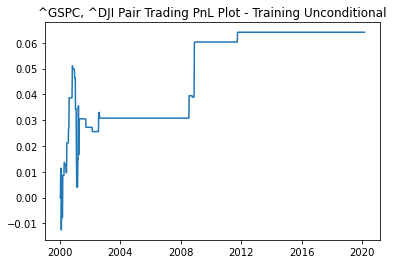

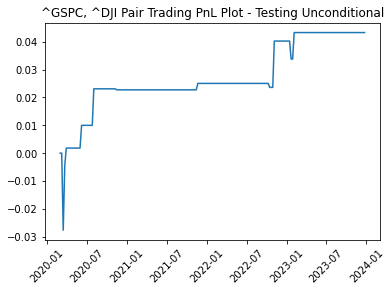

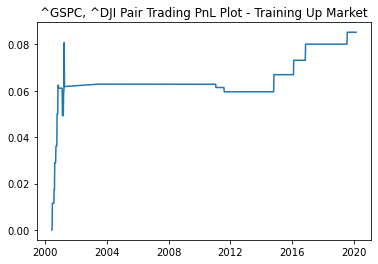

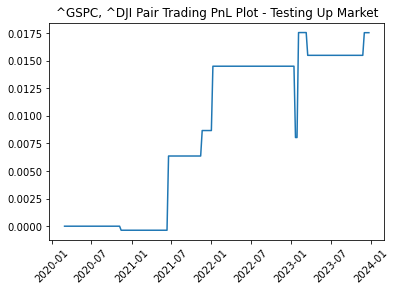

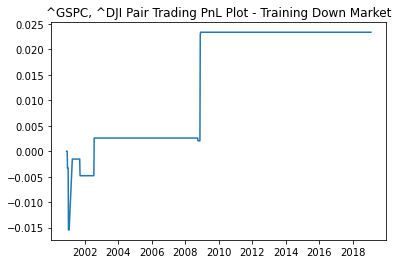

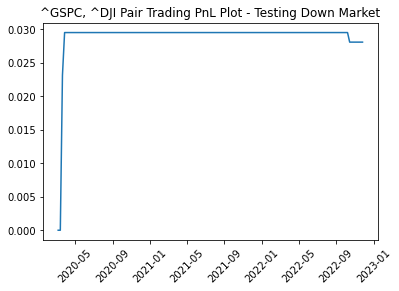

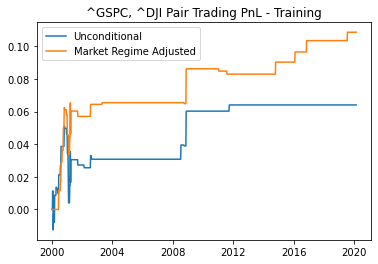

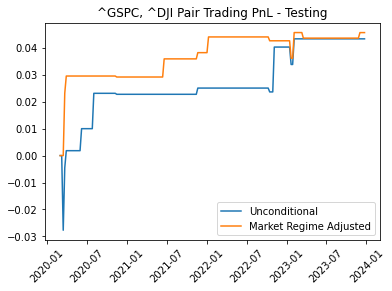

In [20]:
pairs = ['^GSPC-^DJI']
pair_dic_uncond = {}
pair_dic_up = {}
pair_dic_down = {}
pair_dic_split = {}
total_pnl_train_split = pd.DataFrame()
total_pnl_test_split = pd.DataFrame()
threshold = 2.5

for pair in pairs:
    s1, s2 = pair.split('-')
    
    pair_dic_uncond[pair] = pair_trading_summary(s1, 
                                     s2, 
                                     index_log_returns, 
                                     train_index, 
                                     test_index,
                                     threshold = threshold, 
                                     comment = 'Unconditional')
    
    pair_dic_up[pair] = pair_trading_summary(s1, 
                         s2, 
                         index_log_returns, 
                         up_train_index, 
                         up_test_index,
                         threshold = threshold, 
                         comment = 'Up Market')
    
    pair_dic_down[pair] = pair_trading_summary(s1, 
                         s2, 
                         index_log_returns, 
                         down_train_index, 
                         down_test_index,
                         threshold = threshold, 
                         comment = 'Down Market')

    total_pnl_train_split[pair] = pair_dic_up[pair].reindex(train_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(train_index).ffill().fillna(0)['total_pnl']
    total_pnl_test_split[pair] = pair_dic_up[pair].reindex(test_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(test_index).ffill().fillna(0)['total_pnl']

    
    
    plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
    plt.plot(total_pnl_train_split[pair])
    plt.legend(['Unconditional', 'Market Regime Adjusted'])
    plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
    plt.show()
    
    plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
    plt.plot(total_pnl_test_split[pair])
    plt.legend(['Unconditional', 'Market Regime Adjusted'])
    plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
    plt.xticks(rotation = 45)
    plt.show()
    

In [21]:
pairs = ['INCY-VRSN', 'AKAM-FFIV', 'MSI-XRX', 'ADI-INTC', 'AMT-CCI']
pair_dic_uncond = {}
pair_dic_up = {}
pair_dic_down = {}
pair_dic_split = {}
total_pnl_train_split = pd.DataFrame()
total_pnl_test_split = pd.DataFrame()

pair = 'INCY-VRSN'
s1, s2 = pair.split('-')

In [22]:
log_returns_data[s1]

Date
2000-01-01         NaN
2000-01-08    0.233390
2000-01-15    0.175661
2000-01-22   -0.201113
2000-01-29    0.049346
                ...   
2023-11-25    0.005197
2023-12-02    0.012509
2023-12-09    0.130098
2023-12-16    0.008789
2023-12-23   -0.000955
Name: INCY, Length: 1252, dtype: float64

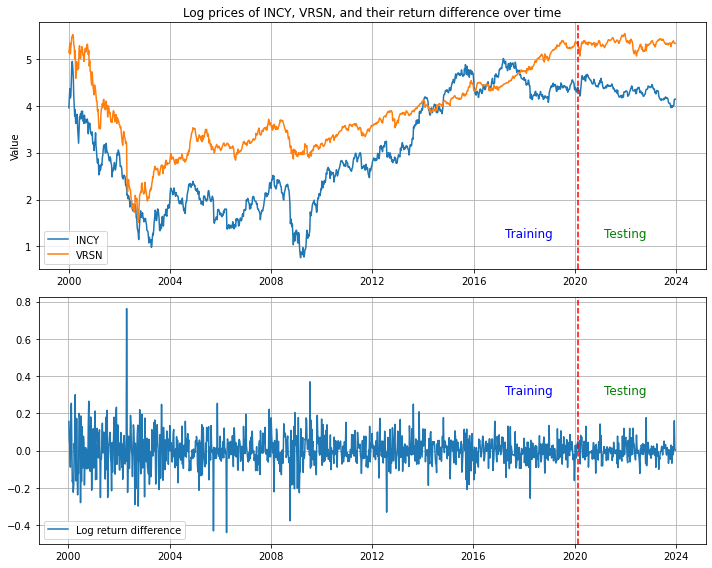

In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pair = 'INCY-VRSN'
s1, s2 = pair.split('-')
# Assuming X1 and X2 are DataFrames with datetime index
# Let's first calculate the difference between X1 and X2
diff = log_returns_data[s1] - log_returns_data[s2]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting the series and their difference over time
#plt.figure(figsize=(10, 8))
axes[0].plot(log_price_data[s1], label = s1)
axes[0].plot(log_price_data[s2], label = s2)
axes[0].axvline(max(train_index), color='r', linestyle='--')

# Add labels
axes[0].text(max(train_index) - timedelta(days=365), 
         1.2, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

axes[0].text(max(train_index) + timedelta(days=365), 
         1.2, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

axes[1].plot(diff, label='Log return difference')
axes[1].axvline(max(train_index), color='r', linestyle='--')

axes[1].text(max(train_index) - timedelta(days=365), 
         0.3, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

axes[1].text(max(train_index) + timedelta(days=365), 
         0.3, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

#axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].set_title(f'Log prices of {s1}, {s2}, and their return difference over time')
axes[0].grid()
axes[0].legend()
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

In [24]:
train_index

DatetimeIndex(['2000-01-01', '2000-01-08', '2000-01-15', '2000-01-22',
               '2000-01-29', '2000-02-05', '2000-02-12', '2000-02-19',
               '2000-02-26', '2000-03-04',
               ...
               '2019-12-21', '2019-12-28', '2020-01-04', '2020-01-11',
               '2020-01-18', '2020-01-25', '2020-02-01', '2020-02-08',
               '2020-02-15', '2020-02-22'],
              dtype='datetime64[ns]', name='Date', length=1052, freq=None)

In [25]:
mean = diff[train_index].mean()
std = diff[train_index].std()

zscore = ((diff - mean)/std).shift().fillna(0)
short_signal = (zscore >= threshold)
long_signal = (zscore <= -threshold)
short_pnl = (short_signal*(-diff)).cumsum()
long_pnl = (long_signal*(diff)).cumsum()
total_pnl = (long_pnl + short_pnl)

#print(short_pnl)

df = pd.concat([zscore, long_signal, long_pnl, short_signal, short_pnl, total_pnl], axis = 1)
df.columns = ['zscore', 'long_signal', 'long_pnl', 'short_signal', 'short_pnl', 'total_pnl']
#print(df)

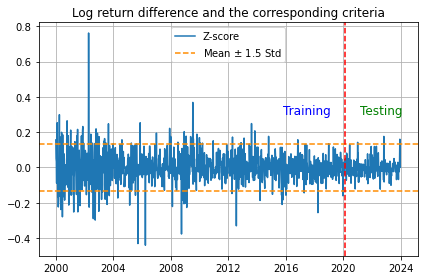

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(figsize=(10, 6))
plt.plot(diff, label = 'Z-score')
plt.axhline(mean-1.5*std, color='darkorange', linestyle='--', label = 'Mean $\pm$ 1.5 Std')
plt.axhline(mean+1.5*std, color='darkorange', linestyle='--')
plt.grid()
plt.legend()
plt.axvline(max(train_index), 
            color='r', 
            linestyle='--')

plt.text(max(train_index) - timedelta(days=365), 
         0.3, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

plt.text(max(train_index) + timedelta(days=365), 
         0.3, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

plt.title('Log return difference and the corresponding criteria')
plt.tight_layout()
plt.show()

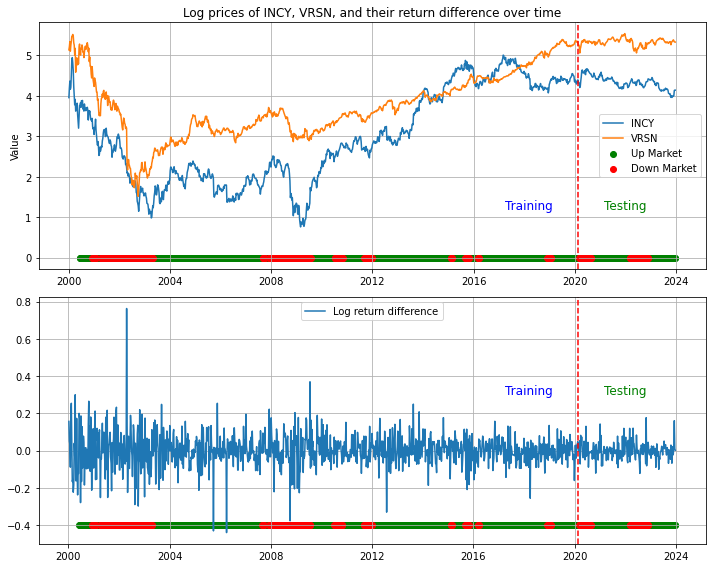

In [27]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pair = 'INCY-VRSN'
s1, s2 = pair.split('-')
# Assuming X1 and X2 are DataFrames with datetime index
# Let's first calculate the difference between X1 and X2
diff = log_returns_data[s1] - log_returns_data[s2]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting the series and their difference over time
#plt.figure(figsize=(10, 8))
axes[0].plot(log_price_data[s1], label = s1)
axes[0].plot(log_price_data[s2], label = s2)
axes[0].axvline(max(train_index), color='r', linestyle='--')

# Add labels
axes[0].text(max(train_index) - timedelta(days=365), 
         1.2, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

axes[0].text(max(train_index) + timedelta(days=365), 
         1.2, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

axes[1].plot(diff, label='Log return difference')
axes[1].axvline(max(train_index), color='r', linestyle='--')

axes[1].text(max(train_index) - timedelta(days=365), 
         0.3, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

axes[1].text(max(train_index) + timedelta(days=365), 
         0.3, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

#axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].set_title(f'Log prices of {s1}, {s2}, and their return difference over time')

up_index = np.concatenate([up_train_index, up_test_index])
down_index = np.concatenate([down_train_index, down_test_index])
axes[0].scatter(up_index, 
                np.zeros(len(up_index)), 
                c = 'green', label = 'Up Market')
axes[0].scatter(down_index, 
                np.zeros(len(down_index)), 
                c = 'red', label = 'Down Market')

axes[0].grid()
axes[0].legend()

axes[1].grid()
axes[1].legend()

axes[1].scatter(up_index, 
                np.zeros(len(up_index))-0.4, 
                c = 'green')
axes[1].scatter(down_index, 
                np.zeros(len(down_index))-0.4, 
                c = 'red')

plt.tight_layout()
plt.show()

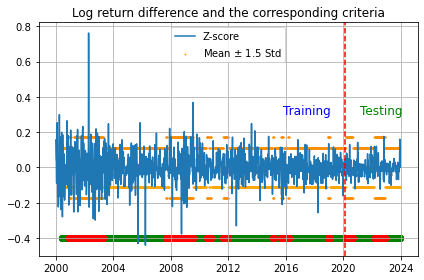

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

up_mean = diff[up_train_index].mean()
up_std = diff[up_train_index].std()

down_mean = diff[down_train_index].mean()
down_std = diff[down_train_index].std()




plt.plot(figsize=(10, 6))
plt.plot(diff, label = 'Z-score')
plt.scatter(up_index, 
            np.zeros(len(up_index)) + up_mean-1.5*up_std, 
            color='orange',  
            label = 'Mean $\pm$ 1.5 Std', s = 1)
plt.scatter(up_index, 
            np.zeros(len(up_index)) + up_mean+1.5*up_std, 
            color='darkorange', s = 1
           )

plt.scatter(down_index, 
            np.zeros(len(down_index)) + down_mean-1.5*down_std, 
            color='darkorange',  
            s = 1)
plt.scatter(down_index, 
            np.zeros(len(down_index)) + down_mean+1.5*down_std, 
            color='darkorange', s = 1
           )

plt.scatter(up_index, 
                np.zeros(len(up_index))-0.4, 
                c = 'green')
plt.scatter(down_index, 
                np.zeros(len(down_index))-0.4, 
                c = 'red')
plt.grid()
plt.legend()
plt.axvline(max(train_index), 
            color='r', 
            linestyle='--')

plt.text(max(train_index) - timedelta(days=365), 
         0.3, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

plt.text(max(train_index) + timedelta(days=365), 
         0.3, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

plt.title('Log return difference and the corresponding criteria')
plt.tight_layout()
plt.show()

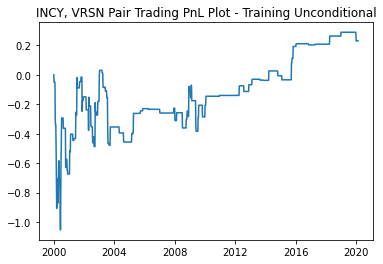

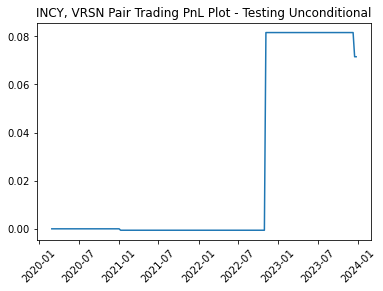

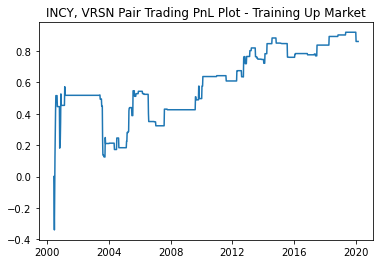

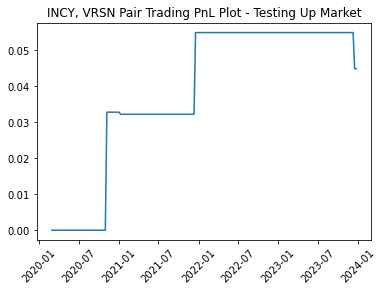

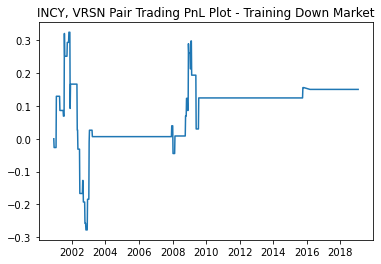

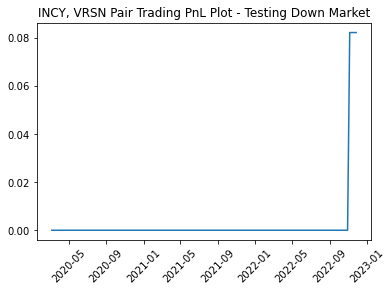

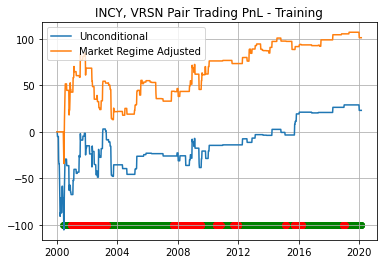

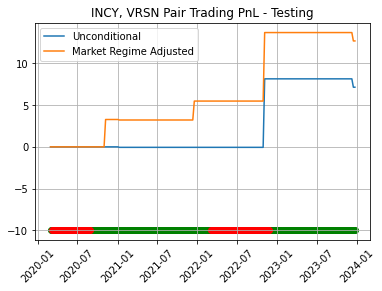

In [29]:
threshold = 1.5
pair_dic_uncond[pair] = pair_trading_summary(s1, 
                                 s2, 
                                 log_returns_data, 
                                 train_index, 
                                 test_index,
                                 threshold = threshold, 
                                 comment = 'Unconditional')

pair_dic_up[pair] = pair_trading_summary(s1, 
                     s2, 
                     log_returns_data, 
                     up_train_index, 
                     up_test_index,
                     threshold = threshold, 
                     comment = 'Up Market')

pair_dic_down[pair] = pair_trading_summary(s1, 
                     s2, 
                     log_returns_data, 
                     down_train_index, 
                     down_test_index,
                     threshold = threshold, 
                     comment = 'Down Market')

total_pnl_train_split[pair] = pair_dic_up[pair].reindex(train_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(train_index).ffill().fillna(0)['total_pnl']
total_pnl_test_split[pair] = pair_dic_up[pair].reindex(test_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(test_index).ffill().fillna(0)['total_pnl']


plt.plot(figsize=(10, 6))
plt.plot(100*pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
plt.plot(100*total_pnl_train_split[pair])
plt.legend(['Unconditional', 'Market Regime Adjusted'])
plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
plt.scatter(up_train_index, 
                np.zeros(len(up_train_index))-100, 
                c = 'green', label = 'Up Market')
plt.scatter(down_train_index, 
                np.zeros(len(down_train_index))-100, 
                c = 'red', label = 'Down Market')
plt.grid()
plt.show()

plt.plot(figsize=(10, 6))
plt.plot(100*pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
plt.plot(100*total_pnl_test_split[pair])
plt.legend(['Unconditional', 'Market Regime Adjusted'])
plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
plt.xticks(rotation = 45)
plt.scatter(up_test_index, 
                np.zeros(len(up_test_index))-10, 
                c = 'green', label = 'Up Market')
plt.scatter(down_test_index, 
                np.zeros(len(down_test_index))-10, 
                c = 'red', label = 'Down Market')
plt.grid()
plt.show()

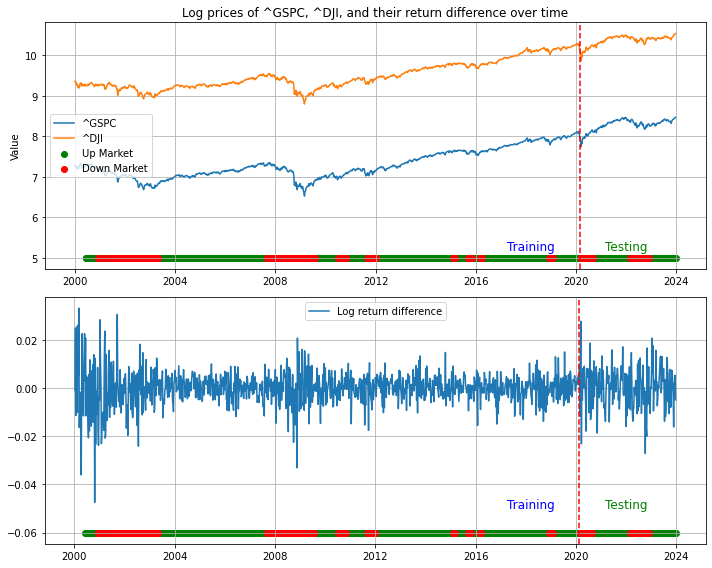

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

pair = '^GSPC-^DJI'
s1, s2 = pair.split('-')
# Assuming X1 and X2 are DataFrames with datetime index
# Let's first calculate the difference between X1 and X2
diff = index_log_returns[s1] - index_log_returns[s2]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plotting the series and their difference over time
#plt.figure(figsize=(10, 8))
axes[0].plot(index_log_prices[s1], label = s1)
axes[0].plot(index_log_prices[s2], label = s2)
axes[0].axvline(max(train_index), color='r', linestyle='--')

# Add labels
axes[0].text(max(train_index) - timedelta(days=365), 
         5.2, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

axes[0].text(max(train_index) + timedelta(days=365), 
         5.2, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

axes[0].scatter(up_index, 
                np.zeros(len(up_index))+5, 
                c = 'green', label = 'Up Market')
axes[0].scatter(down_index, 
                np.zeros(len(down_index))+5, 
                c = 'red', label = 'Down Market')

axes[1].plot(diff, label='Log return difference')
axes[1].axvline(max(train_index), color='r', linestyle='--')

axes[1].text(max(train_index) - timedelta(days=365), 
         -0.05, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

axes[1].text(max(train_index) + timedelta(days=365), 
         -0.05, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')
axes[1].scatter(up_index, 
                np.zeros(len(up_index))-0.06, 
                c = 'green')
axes[1].scatter(down_index, 
                np.zeros(len(down_index))-0.06, 
                c = 'red')


#axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].set_title(f'Log prices of {s1}, {s2}, and their return difference over time')



axes[0].grid()
axes[0].legend()

axes[1].grid()
axes[1].legend()


plt.tight_layout()
plt.show()

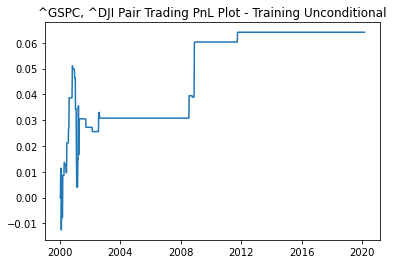

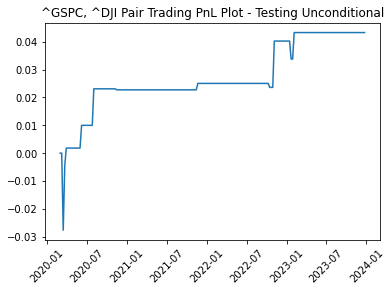

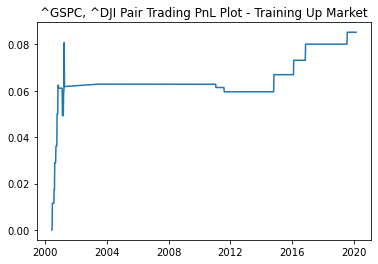

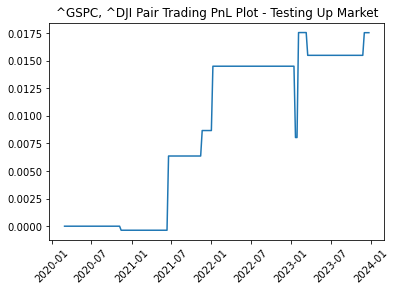

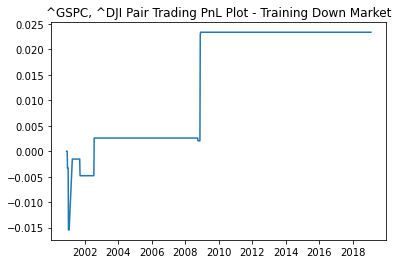

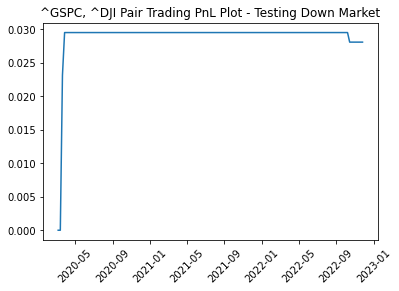

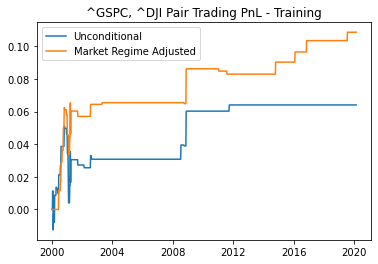

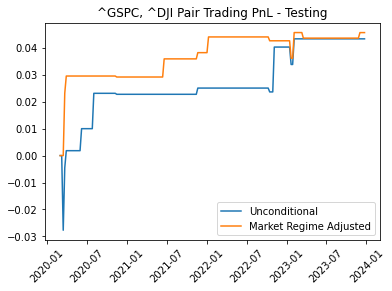

In [31]:
pairs = ['^GSPC-^DJI']
pair_dic_uncond = {}
pair_dic_up = {}
pair_dic_down = {}
pair_dic_split = {}
total_pnl_train_split = pd.DataFrame()
total_pnl_test_split = pd.DataFrame()
threshold = 2.5

for pair in pairs:
    s1, s2 = pair.split('-')
    
    pair_dic_uncond[pair] = pair_trading_summary(s1, 
                                     s2, 
                                     index_log_returns, 
                                     train_index, 
                                     test_index,
                                     threshold = threshold, 
                                     comment = 'Unconditional')
    
    pair_dic_up[pair] = pair_trading_summary(s1, 
                         s2, 
                         index_log_returns, 
                         up_train_index, 
                         up_test_index,
                         threshold = threshold, 
                         comment = 'Up Market')
    
    pair_dic_down[pair] = pair_trading_summary(s1, 
                         s2, 
                         index_log_returns, 
                         down_train_index, 
                         down_test_index,
                         threshold = threshold, 
                         comment = 'Down Market')

    total_pnl_train_split[pair] = pair_dic_up[pair].reindex(train_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(train_index).ffill().fillna(0)['total_pnl']
    total_pnl_test_split[pair] = pair_dic_up[pair].reindex(test_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(test_index).ffill().fillna(0)['total_pnl']

    
    
    plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
    plt.plot(total_pnl_train_split[pair])
    plt.legend(['Unconditional', 'Market Regime Adjusted'])
    plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
    plt.show()
    
    plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
    plt.plot(total_pnl_test_split[pair])
    plt.legend(['Unconditional', 'Market Regime Adjusted'])
    plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
    plt.xticks(rotation = 45)
    plt.show()
    

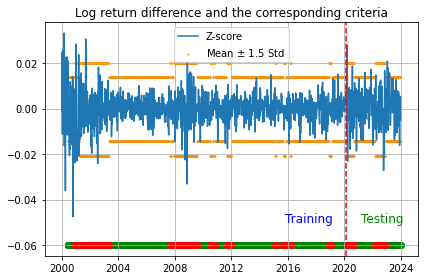

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

up_mean = diff[up_train_index].mean()
up_std = diff[up_train_index].std()

down_mean = diff[down_train_index].mean()
down_std = diff[down_train_index].std()




plt.plot(figsize=(10, 6))
plt.plot(diff, label = 'Z-score')
plt.scatter(up_index, 
            np.zeros(len(up_index)) + up_mean-2.5*up_std, 
            color='darkorange',  
            label = 'Mean $\pm$ 1.5 Std', s = 1)
plt.scatter(up_index, 
            np.zeros(len(up_index)) + up_mean+2.5*up_std, 
            color='darkorange', s = 1
           )

plt.scatter(down_index, 
            np.zeros(len(down_index)) + down_mean-2.5*down_std, 
            color='darkorange',  
            s = 1)
plt.scatter(down_index, 
            np.zeros(len(down_index)) + down_mean+2.5*down_std, 
            color='darkorange', s = 1
           )

plt.scatter(up_index, 
                np.zeros(len(up_index))-0.06, 
                c = 'green')
plt.scatter(down_index, 
                np.zeros(len(down_index))-0.06, 
                c = 'red')
plt.grid()
plt.legend()
plt.axvline(max(train_index), 
            color='r', 
            linestyle='--')

plt.text(max(train_index) - timedelta(days=365), 
         -0.05, 
         'Training', 
         ha='right', 
         fontsize=12, 
         color='blue')

plt.text(max(train_index) + timedelta(days=365), 
         -0.05, 
         'Testing', 
         ha='left', 
         fontsize=12, 
         color='green')

plt.title('Log return difference and the corresponding criteria')
plt.tight_layout()
plt.show()

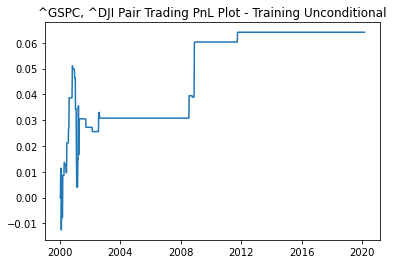

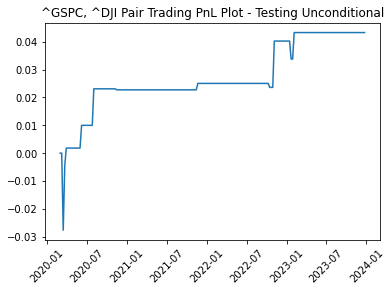

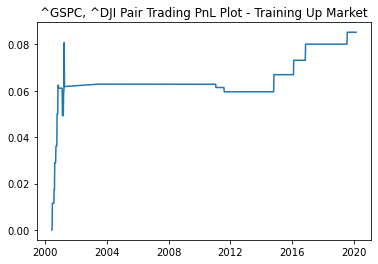

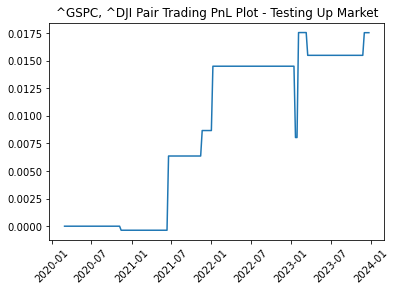

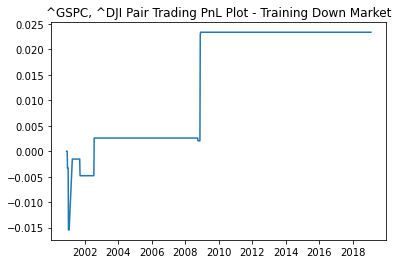

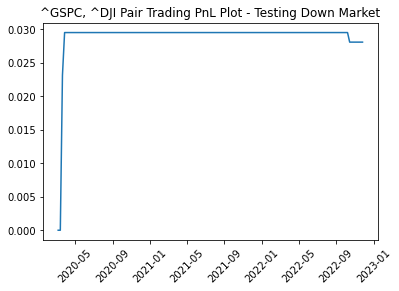

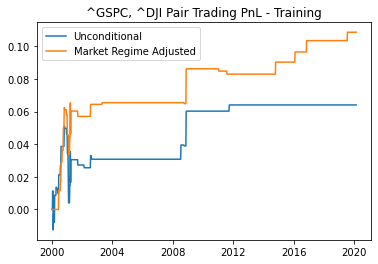

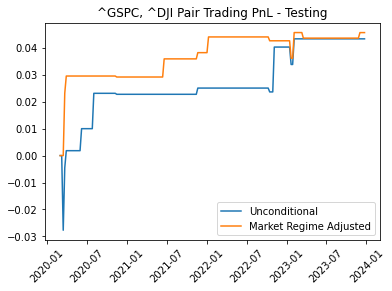

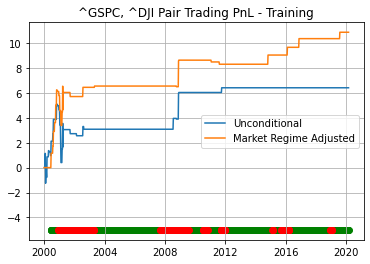

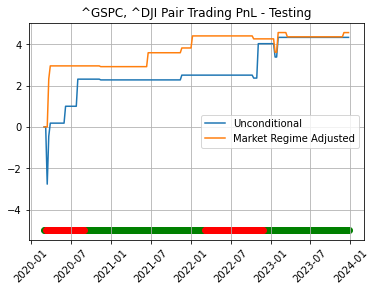

In [33]:
pairs = ['^GSPC-^DJI']
pair_dic_uncond = {}
pair_dic_up = {}
pair_dic_down = {}
pair_dic_split = {}
total_pnl_train_split = pd.DataFrame()
total_pnl_test_split = pd.DataFrame()
threshold = 1.5

for pair in pairs:
    s1, s2 = pair.split('-')
    
    pair_dic_uncond[pair] = pair_trading_summary(s1, 
                                     s2, 
                                     index_log_returns, 
                                     train_index, 
                                     test_index,
                                     threshold = threshold, 
                                     comment = 'Unconditional')
    
    pair_dic_up[pair] = pair_trading_summary(s1, 
                         s2, 
                         index_log_returns, 
                         up_train_index, 
                         up_test_index,
                         threshold = threshold, 
                         comment = 'Up Market')
    
    pair_dic_down[pair] = pair_trading_summary(s1, 
                         s2, 
                         index_log_returns, 
                         down_train_index, 
                         down_test_index,
                         threshold = threshold, 
                         comment = 'Down Market')

    total_pnl_train_split[pair] = pair_dic_up[pair].reindex(train_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(train_index).ffill().fillna(0)['total_pnl']
    total_pnl_test_split[pair] = pair_dic_up[pair].reindex(test_index).ffill().fillna(0)['total_pnl'] + pair_dic_down[pair].reindex(test_index).ffill().fillna(0)['total_pnl']

    
    
    plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
    plt.plot(total_pnl_train_split[pair])
    plt.legend(['Unconditional', 'Market Regime Adjusted'])
    plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
    plt.show()
    
    plt.plot(pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
    plt.plot(total_pnl_test_split[pair])
    plt.legend(['Unconditional', 'Market Regime Adjusted'])
    plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
    plt.xticks(rotation = 45)
    plt.show()
    
plt.plot(figsize=(10, 6))
plt.plot(100*pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(train_index), 'total_pnl'])
plt.plot(100*total_pnl_train_split[pair])
plt.legend(['Unconditional', 'Market Regime Adjusted'])
plt.title(f'{s1}, {s2} Pair Trading PnL - Training')
plt.scatter(up_train_index, 
                np.zeros(len(up_train_index))-5, 
                c = 'green', label = 'Up Market')
plt.scatter(down_train_index, 
                np.zeros(len(down_train_index))-5, 
                c = 'red', label = 'Down Market')
plt.grid()
plt.show()

plt.plot(figsize=(10, 6))
plt.plot(100*pair_dic_uncond[pair].loc[pair_dic_uncond[pair].index.isin(test_index), 'total_pnl'])
plt.plot(100*total_pnl_test_split[pair])
plt.legend(['Unconditional', 'Market Regime Adjusted'])
plt.title(f'{s1}, {s2} Pair Trading PnL - Testing')
plt.xticks(rotation = 45)
plt.scatter(up_test_index, 
                np.zeros(len(up_test_index))-5, 
                c = 'green', label = 'Up Market')
plt.scatter(down_test_index, 
                np.zeros(len(down_test_index))-5, 
                c = 'red', label = 'Down Market')
plt.grid()
plt.show()